<a href="https://colab.research.google.com/github/swush41/FinanceRateCalculator-App/blob/main/MobilabTask1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MobilabTask

- I have chosen Colab Research to utilize high ram capacity. Coded the pipeline online then switched to the local host.
- As data reader I first used Pandas which then did not meet my expectation with the large dataset and my ram capacity was exceeded.
- Then I have switched to Pyspark and without exceeding the ram capacity I could process over 60GB data.

In [1]:
!pip3 install pyspark

In [2]:
import pandas as pd
import pyspark
from datetime import datetime, timedelta
from pyspark.sql import functions as F, types as T
from pyspark.sql.functions import *
from pyspark import SparkFiles
from functools import reduce
from pyspark import SparkContext, SparkConf
from pyspark.sql import DataFrame,SparkSession

In [3]:
# Build spark

spark = SparkSession.builder \
    .appName("Python Spark SQL") \
    .master("local") \
    .config("spark.some.config.option").getOrCreate()

In [4]:
 # Set a dynamic csv url 
 
taxi_data_url="https://s3.amazonaws.com/nyc-tlc/trip+data/COLOR_tripdata_DATE.csv"
prefix = "COLOR_tripdata_DATE.csv"
COLORS=["yellow","green"]

In [5]:
# Select last three years by going backwards in history which makes the future imports automatic

starting_date = datetime(datetime.now().year-3,1,1)
starting_year = starting_date.year
monthy_date_list = pd.date_range(start=starting_date.strftime("%m/%Y"), end=datetime(datetime.now().year,1,1).strftime("%m/%Y"), freq='1M').tolist()
monthy_date_list.reverse()
monthy_date_list

[Timestamp('2020-12-31 00:00:00', freq='M'),
 Timestamp('2020-11-30 00:00:00', freq='M'),
 Timestamp('2020-10-31 00:00:00', freq='M'),
 Timestamp('2020-09-30 00:00:00', freq='M'),
 Timestamp('2020-08-31 00:00:00', freq='M'),
 Timestamp('2020-07-31 00:00:00', freq='M'),
 Timestamp('2020-06-30 00:00:00', freq='M'),
 Timestamp('2020-05-31 00:00:00', freq='M'),
 Timestamp('2020-04-30 00:00:00', freq='M'),
 Timestamp('2020-03-31 00:00:00', freq='M'),
 Timestamp('2020-02-29 00:00:00', freq='M'),
 Timestamp('2020-01-31 00:00:00', freq='M'),
 Timestamp('2019-12-31 00:00:00', freq='M'),
 Timestamp('2019-11-30 00:00:00', freq='M'),
 Timestamp('2019-10-31 00:00:00', freq='M'),
 Timestamp('2019-09-30 00:00:00', freq='M'),
 Timestamp('2019-08-31 00:00:00', freq='M'),
 Timestamp('2019-07-31 00:00:00', freq='M'),
 Timestamp('2019-06-30 00:00:00', freq='M'),
 Timestamp('2019-05-31 00:00:00', freq='M'),
 Timestamp('2019-04-30 00:00:00', freq='M'),
 Timestamp('2019-03-31 00:00:00', freq='M'),
 Timestamp

In [6]:
len(monthy_date_list) # for debugging purposes
monthy_date_list[0]

Timestamp('2020-12-31 00:00:00', freq='M')

In [7]:
 # Defined a function that merges multiple dataframes after collected
 
 def UnionFunc(*dfs):
    return reduce(DataFrame.unionAll, dfs)

In [8]:
# Run two for loops with Color and Date parameters changing.
# Collect datasets and push them in a list

df_list = []
for color in COLORS:
    if color == 'green':
      pick_up_time = 'lpep_pickup_datetime'
      drop_off_time = 'lpep_dropoff_datetime'
    else:
      pick_up_time = 'tpep_pickup_datetime'
      drop_off_time = 'tpep_dropoff_datetime'
    for month_date in monthy_date_list:
      data_url = taxi_data_url.replace("COLOR",color).replace("DATE",month_date.strftime("%Y-%m"))
      print(data_url) 
      prefix = 'COLOR_tripdata_DATE.csv'
      file_prefix = prefix.replace("COLOR",color).replace("DATE",month_date.strftime("%Y-%m"))
      spark.sparkContext.addFile(data_url)
      df = spark.read.csv("file://"+SparkFiles.get(file_prefix), header=True, inferSchema= True).select('VendorID',pick_up_time,drop_off_time,'passenger_count','trip_distance','total_amount')
      
      if color == 'green': ## For green taxis the column name of timestamp is set the same of the yellow
        df = df.withColumnRenamed("lpep_dropoff_datetime","tpep_dropoff_datetime").\
                withColumnRenamed( "lpep_pickup_datetime","tpep_pickup_datetime")
      
      print(color)
      df = df.withColumn('color',lit(color)) # add column "color"
      df_list.append(df) # Append collected dataframes in a list
      print(df.count())
      break           
    #break

https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2020-12.csv
yellow
1461897
https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2020-12.csv
green
83130


In [9]:
print(len(df_list))

2


In [10]:
# Get the first item of the list as a dataframe to append others on top of it
all_df = df_list[0]
all_df.show()

+--------+--------------------+---------------------+---------------+-------------+------------+------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|total_amount| color|
+--------+--------------------+---------------------+---------------+-------------+------------+------+
|       1| 2020-12-01 00:07:13|  2020-12-01 00:18:12|              1|          7.6|       33.92|yellow|
|       1| 2020-12-01 00:41:19|  2020-12-01 00:49:45|              1|          1.6|       14.75|yellow|
|       2| 2020-12-01 00:33:40|  2020-12-01 01:00:35|              1|        16.74|       63.92|yellow|
|       2| 2020-12-01 00:02:15|  2020-12-01 00:13:09|              1|         4.16|        18.8|yellow|
|       2| 2020-12-01 00:37:42|  2020-12-01 00:45:11|              1|         2.22|         9.8|yellow|
|       1| 2020-12-01 00:27:47|  2020-12-01 00:45:40|              0|          8.4|       40.92|yellow|
|       2| 2020-12-01 00:40:47|  2020-12-01 00:57:03|           

In [11]:
 ## Union listed dataframes onto all_df and get unique

for i in range(1,len(df_list)):
  all_df = UnionFunc(all_df,df_list[i]).distinct()
all_df.count()

1545026

In [12]:
## In order to evaluate data on hour and weekday of the dataset, new columns of pickup_hour and dropoff_hour added

edited_timestamp_df = all_df.withColumn("tpep_pickup_datetime",
                  to_timestamp(col("tpep_pickup_datetime")))\
                  .withColumn("pickup_hour", hour(col("tpep_pickup_datetime")).alias("pickup_hour"))\
                  .withColumn("tpep_dropoff_datetime",
                  to_timestamp(col("tpep_dropoff_datetime")))\
                  .withColumn("dropoff_hour", hour(col("tpep_dropoff_datetime")).alias("dropoff_hour"))\
                  \
                          .withColumn("tpep_pickup_datetime", # timestamp is here converted to weekdays of the date 
                          to_timestamp(col("tpep_pickup_datetime")))\
                          .withColumn("pickup_week_day", date_format(col("tpep_pickup_datetime"), "EEEE")) \
                          .withColumn("tpep_dropoff_datetime",
                          to_timestamp(col("tpep_dropoff_datetime")))\
                          .withColumn("dropoff_week_day", date_format(col("tpep_dropoff_datetime"), "EEEE"))

edited_timestamp_df.show(10)

+--------+--------------------+---------------------+---------------+-------------+------------+------+-----------+------------+---------------+----------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|total_amount| color|pickup_hour|dropoff_hour|pickup_week_day|dropoff_week_day|
+--------+--------------------+---------------------+---------------+-------------+------------+------+-----------+------------+---------------+----------------+
|       2| 2020-12-01 00:01:54|  2020-12-01 00:12:12|              1|         1.93|       15.96|yellow|          0|           0|        Tuesday|         Tuesday|
|       2| 2020-12-01 00:48:45|  2020-12-01 01:03:12|              2|         8.74|        32.3|yellow|          0|           1|        Tuesday|         Tuesday|
|       1| 2020-12-01 01:03:56|  2020-12-01 01:08:49|              1|          1.6|       12.95|yellow|          1|           1|        Tuesday|         Tuesday|
|       1| 2020-12-01 05:53:

In [13]:
edited_timestamp_df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- color: string (nullable = false)
 |-- pickup_hour: integer (nullable = true)
 |-- dropoff_hour: integer (nullable = true)
 |-- pickup_week_day: string (nullable = true)
 |-- dropoff_week_day: string (nullable = true)



In [44]:
## Convert to parquet
edited_timestamp_df.write.parquet("taxiData.parquet")

In [ ]:
## Convert to avro format after installing pyspark --packages org.apache.spark:spark-avro_2.12:2.4.4
edited_timestamp_df.select("*").write.format("avro").save('taxi_Data.avro')


Write three requested queries to check if the dataset loaded accurately


In [15]:
# Day of the week in 2019 and 2020 which has the lowest number of single rider trips
# get only passenger_count = 1
# count with days of the week
dayOfTheWeek_sql = edited_timestamp_df.select(year('tpep_pickup_datetime').alias('year'),'passenger_count','pickup_week_day').filter('passenger_count= 1')\
                                            .filter( (F.col('year') == 2020) | (F.col('year') == 2019) ).groupBy('year','passenger_count','pickup_week_day').count()
dayOfTheWeek_sql.show()

+----+---------------+---------------+------+
|year|passenger_count|pickup_week_day| count|
+----+---------------+---------------+------+
|2020|              1|        Tuesday|202595|
|2020|              1|       Saturday|116016|
|2020|              1|         Sunday| 95094|
|2020|              1|         Monday|142707|
|2020|              1|      Wednesday|198610|
|2020|              1|         Friday|144419|
|2020|              1|       Thursday|170173|
+----+---------------+---------------+------+



In [16]:
# Return the week day with least single passenger rides
dayOfTheWeek_sql.orderBy('count').show(1)

+----+---------------+---------------+-----+
|year|passenger_count|pickup_week_day|count|
+----+---------------+---------------+-----+
|2020|              1|         Sunday|95094|
+----+---------------+---------------+-----+
only showing top 1 row



In [17]:
#The top 3 busiest hours

edited_timestamp_df.groupBy('pickup_hour').count().orderBy(col("count").desc()).show(3)

+-----------+------+
|pickup_hour| count|
+-----------+------+
|         15|130027|
|         14|128264|
|         16|121423|
+-----------+------+
only showing top 3 rows



Bonus 1) 
- In case a data analysis needed to put in action on the relation between weather and taxi driving, I have found a dataset as an exapmle (unfortunately not NYC) to merge them 

In [34]:
# Rename the columns in order to join on that specific column

filepath = 'https://corgis-edu.github.io/corgis/datasets/csv/weather/weather.csv'
spark.sparkContext.addFile(filepath)
weather_df = spark.read.csv("file://"+SparkFiles.get('weather.csv'), header=True)
weather_df = weather_df.withColumnRenamed('Date.Full','join_date')
weather_df.show()

+------------------+----------+----------+------------+---------+--------------------+------------+--------------------+-------------+-------------------------+-------------------------+-------------------------+-------------------+---------------+
|Data.Precipitation| join_date|Date.Month|Date.Week of|Date.Year|        Station.City|Station.Code|    Station.Location|Station.State|Data.Temperature.Avg Temp|Data.Temperature.Max Temp|Data.Temperature.Min Temp|Data.Wind.Direction|Data.Wind.Speed|
+------------------+----------+----------+------------+---------+--------------------+------------+--------------------+-------------+-------------------------+-------------------------+-------------------------+-------------------+---------------+
|               0.0|2016-01-03|         1|           3|     2016|          Birmingham|         BHM|      Birmingham, AL|      Alabama|                       39|                       46|                       32|                 33|           4.33|
|   

In [40]:
# In order not to merge dataset from 2016 and 2020 and return a total full of null dataset, I here get taxi data from 2016 as an example.

spark.sparkContext.addFile('https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2016-01.csv')
example_df = spark.read.csv("file://"+SparkFiles.get('green_tripdata_2016-01.csv'), header=True, inferSchema= True).select('total_amount','trip_distance','lpep_pickup_datetime')
example_df.show(10)

+------------+-------------+--------------------+
|total_amount|trip_distance|lpep_pickup_datetime|
+------------+-------------+--------------------+
|       11.16|         1.46| 2016-01-01 00:29:24|
|        16.8|         3.56| 2016-01-01 00:19:39|
|       22.25|         3.79| 2016-01-01 00:19:33|
|        14.8|         3.01| 2016-01-01 00:22:12|
|        13.3|         2.55| 2016-01-01 00:24:01|
|         8.3|         1.37| 2016-01-01 00:32:59|
|         6.3|         0.57| 2016-01-01 00:34:42|
|         8.3|         1.01| 2016-01-01 00:31:23|
|        15.3|         2.46| 2016-01-01 00:24:40|
|        11.9|         1.61| 2016-01-01 00:28:59|
+------------+-------------+--------------------+
only showing top 10 rows



In [41]:
# Divide pickup datetime of taxi data into year to merge with weather data

join_data = example_df.withColumn("lpep_pickup_datetime",
                  to_timestamp(col("lpep_pickup_datetime")))\
                  .withColumn("join_date", to_date(col("lpep_pickup_datetime")).alias("join_date"))
join_data.show()       

+------------+-------------+--------------------+----------+
|total_amount|trip_distance|lpep_pickup_datetime| join_date|
+------------+-------------+--------------------+----------+
|       11.16|         1.46| 2016-01-01 00:29:24|2016-01-01|
|        16.8|         3.56| 2016-01-01 00:19:39|2016-01-01|
|       22.25|         3.79| 2016-01-01 00:19:33|2016-01-01|
|        14.8|         3.01| 2016-01-01 00:22:12|2016-01-01|
|        13.3|         2.55| 2016-01-01 00:24:01|2016-01-01|
|         8.3|         1.37| 2016-01-01 00:32:59|2016-01-01|
|         6.3|         0.57| 2016-01-01 00:34:42|2016-01-01|
|         8.3|         1.01| 2016-01-01 00:31:23|2016-01-01|
|        15.3|         2.46| 2016-01-01 00:24:40|2016-01-01|
|        11.9|         1.61| 2016-01-01 00:28:59|2016-01-01|
|        9.12|         0.72| 2016-01-01 00:32:25|2016-01-01|
|        5.76|         0.32| 2016-01-01 00:37:51|2016-01-01|
|        15.8|         3.54| 2016-01-01 00:21:39|2016-01-01|
|         7.3|          

In [43]:
# Merge two datasets based on a common join_date column

merged_df = weather_df.join(join_data, on=["join_date"] , how="inner")
merged_df.show()

+----------+------------------+----------+------------+---------+------------+------------+----------------+-------------+-------------------------+-------------------------+-------------------------+-------------------+---------------+------------+-------------+--------------------+
| join_date|Data.Precipitation|Date.Month|Date.Week of|Date.Year|Station.City|Station.Code|Station.Location|Station.State|Data.Temperature.Avg Temp|Data.Temperature.Max Temp|Data.Temperature.Min Temp|Data.Wind.Direction|Data.Wind.Speed|total_amount|trip_distance|lpep_pickup_datetime|
+----------+------------------+----------+------------+---------+------------+------------+----------------+-------------+-------------------------+-------------------------+-------------------------+-------------------+---------------+------------+-------------+--------------------+
|2016-01-03|               0.0|         1|           3|     2016|    Sheridan|         SHR|    Sheridan, WY|      Wyoming|                       

Bonus 2) 
- Excel row limit is 1048576 rows therefore the dataframe_list could be divided into pieces to fit in excel sheets depending on the use case and the date  interval needed.
- If the analysis is being done in aggregation, Excel Power Pivot can process up to 50 million rows.

For deployment I installed and lauch Airflow in order to schedule PySpark jon on my local host 8080 by compiling following commands on Ubuntu terminal;


```
pip3 install apache-airflow==2.0.2

# initialize the database
airflow db init

airflow users create \
    --username admin \
    --firstname Berkay \
    --lastname Sahin \
    --role Admin \
    --email sahinberkay10@icloud.com

airflow webserver --port 8080

airflow scheduler



```






Then connected my Colab Jupyter Notebook to my local host 8888 in order to be able to set schedule.
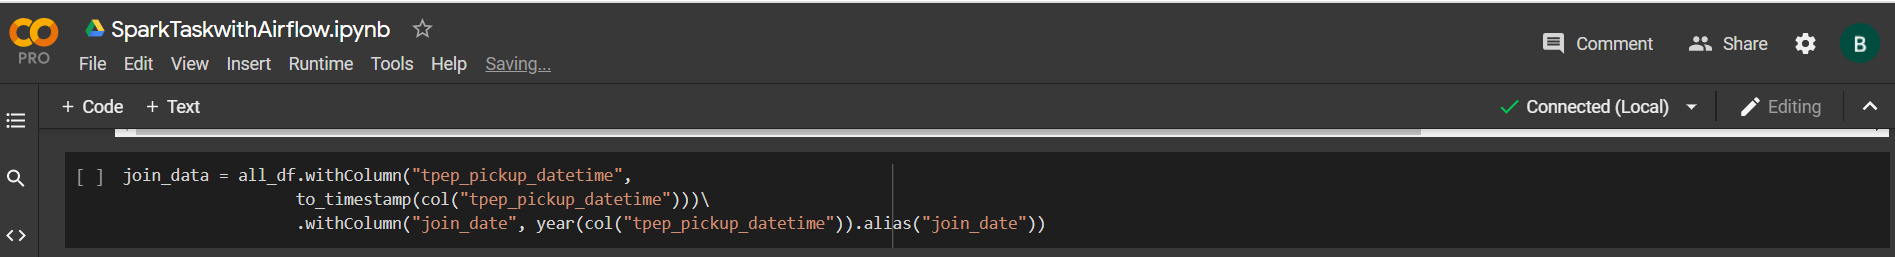

Then tried to create a job to execute on my local host beginning from 1. of January 2022 on a annually basis.

In [ ]:
from airflow import DAG
from airflow.operators.python import PythonOperator

def _run_Task():
  return print("Up and running!")

with DAG("MobilabTask", 
    start_date=datetime(2022,1,1),
    schedule_interval="@yearly" ,
    catchup=False) as dag:

    runTask = PythonOperator(
        task_id ="runTask",
        python_callable=_run_Task
    )